In [17]:
import numpy as np
import torch.nn as nn
import os
import matplotlib.pyplot as plt

In [18]:
filename = os.listdir('./data')
filename

['baboon.raw', 'lena.raw', 'Noisy.raw', 'F16.raw']

In [19]:
all_img = []
all_1Dimg = []
for i in filename:
    raw = np.fromfile(os.path.join('./data', i), dtype='uint8')
    all_img.append(raw.reshape(512,512))
    all_1Dimg.append(raw)

In [26]:
class Guided_Filter():
    def __init__(self, noisy, r=1, eps=0.01):
        B_image = self.Bilateral_filter(noisy, 15, 35, 3)
        self.guidedfilter(B_image, noisy, r, eps)
        plt.title('After Guided Filter', fontsize=10)
        
    def boxfilter(self, img, r):
        (rows, cols) = img.shape
        imDst = np.zeros_like(img)

        imCum = np.cumsum(img, 0)
        imDst[0 : r+1, :] = imCum[r : 2*r+1, :]
        imDst[r+1 : rows-r, :] = imCum[2*r+1 : rows, :] - imCum[0 : rows-2*r-1, :]
        imDst[rows-r: rows, :] = np.tile(imCum[rows-1, :], [r, 1]) - imCum[rows-2*r-1 : rows-r-1, :]

        imCum = np.cumsum(imDst, 1)
        imDst[:, 0 : r+1] = imCum[:, r : 2*r+1]
        imDst[:, r+1 : cols-r] = imCum[:, 2*r+1 : cols] - imCum[:, 0 : cols-2*r-1]
        imDst[:, cols-r: cols] = np.tile(imCum[:, cols-1], [r, 1]).T - imCum[:, cols-2*r-1 : cols-r-1]
        return imDst

    def guidedfilter(self, I, p, r, eps):
        if I.max()>1:
            I = I/255.0
        if p.max()>1:
            p = p/255.0

        (rows, cols) = I.shape
        N = self.boxfilter(np.ones([rows, cols]), r)

        meanI = self.boxfilter(I, r) / N
        meanP = self.boxfilter(p, r) / N
        meanIp = self.boxfilter(I * p, r) / N
        covIp = meanIp - meanI * meanP

        meanII = self.boxfilter(I * I, r) / N
        varI = meanII - meanI * meanI

        a = covIp / (varI + eps)
        b = meanP - a * meanI

        meanA = self.boxfilter(a, r) / N
        meanB = self.boxfilter(b, r) / N

        q = meanA * I + meanB

        plt.imshow(q ,cmap='gray')
        return q
    
    def Bilateral_filter(self, img_in, sigma_c, sigma_s, kernal_size ):

        # check the input
    #     if not isinstance( img_in, np.ndarray ) or img_in.dtype != 'float32' or img_in.ndim != 2:
    #         raise ValueError('Expected a 2D numpy.ndarray with float32 elements')
        img = img_in.astype(np.float32)/255.0

        # make a simple Gaussian function taking the squared radius
        gaussian = lambda r2, sigma: (np.exp(-r2**2/(2*sigma**2)))

        img = np.array(img)
        height = img.shape[0]
        width = img.shape[1]
        newimg = np.zeros((height, width))
        halfk= int((kernal_size-1)/2)


        sideLength = kernal_size
        W_c = np.zeros((sideLength, sideLength))
        for i in range(sideLength):
            for j in range(sideLength):
                W_c[i, j] = gaussian((i-(kernal_size-1)/2)**2+(j-(kernal_size-1)/2)**2, sigma_c )

        newdata = np.zeros((height, width))            
        for i in range(halfk, height-halfk):
            for j in range(halfk, width-halfk):
                r2_s = img[i,j]-img[i-halfk:i+halfk+1, j-halfk:j+halfk+1]
                W_s = gaussian(r2_s, sigma_s)

                result = W_c*W_s*img[i-halfk:i+halfk+1, j-halfk:j+halfk+1]
                wgt_sum = W_c*W_s
                newdata[i, j] = (result.sum()/wgt_sum.sum())
        #newImage = Image.fromarray(newimg)

        # normalize the result and return
        return newdata
    
    #def Guided_Filter(self, noisy):
        

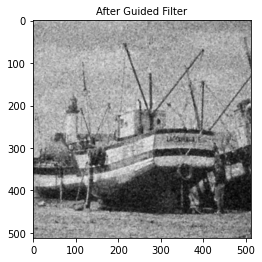

In [28]:
Guided_Filter(all_img[2], 1, 0.02)